In [20]:
# CORE LIBRARIES
import pandas as pd
import numpy as np
import re
import time
from collections import Counter

# DISPLAY SETTINGS
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# SCIKIT-LEARN: DATA PROCESSING & MODELING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    average_precision_score
)




# METRICS
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    auc
)

# IMBALANCED-LEARN
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier

# BOOSTING LIBRARIES
import xgboost as xgb
import lightgbm as lgb

# MLFLOW TRACKING
import mlflow
import mlflow.sklearn
import mlflow.lightgbm
import mlflow.xgboost

# HYPER-PARAMETER TUNING
import optuna


# MODEL DEPLOYMENT
import joblib


In [5]:
# READ PROCESSED DATA (data transformed in previous step)
user_data = pd.read_csv(r"processed-data\loan-processed-data.csv")

In [6]:
user_data['Default'] = user_data['Default'].astype(int)
# Sanitize column names globally
user_data.columns = [col.strip().replace(" ", "_") for col in user_data.columns]

In [7]:
# Objective: To evaluate multiple models with and without scaling, using different sampling and thresholding techniques to handle class imbalance and improve default prediction accuracy.


# Set MLflow experiment
mlflow.set_experiment("Task: Loan Default Model Comparison")

# Columns to scale
columns_to_scale = [
    'Client_Income',
    'Population_Region_Relative', 'Age_Days', 'Employed_Days',
    'Registration_Days', 'ID_Days', 'Score_Source_2',
    'Score_Source_3', 'Phone_Change', 'Credit_Bureau'
]

# Split and scale
def stratified_split_and_scale(df, target_col='Default', test_size=0.2, random_state=42):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )

    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    return X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, scaler

# Resampling logic
def apply_resampling(X, y, method='none'):
    print(f"\n {method.upper()} - Before: {Counter(y)}")
    if method == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
    elif method == 'oversample':
        sampler = RandomOverSampler(random_state=42)
    elif method == 'smote':
        sampler = SMOTE(random_state=42)
    elif method == 'smote_tomek':
        sampler = SMOTETomek(random_state=42)
    else:
        return X, y

    X_res, y_res = sampler.fit_resample(X, y)
    print(f"{method.upper()} - After: {Counter(y_res)}")
    return X_res, y_res

# Evaluation logic
def evaluate_with_mlflow(model, X_test, y_test, model_name, sampling_method, X_train, y_train, train_time, custom_threshold):
    # custom_threshold = 0.3
    with mlflow.start_run(run_name=f"{model_name} with {sampling_method} with threshold {custom_threshold}" ):

        mlflow.set_tag("dataset", "loan_default_v2")
        # Log parameters
        mlflow.log_param("Model", model_name)
        mlflow.log_param("Sampling", sampling_method)
        mlflow.log_param("custom_threshold", custom_threshold)
        mlflow.log_param("Dataset", "loan_default_v2" )

        
# Check if model supports probability output
        pr_auc = None
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_proba >= custom_threshold).astype(int)

            # Log PR AUC
            pr_auc = average_precision_score(y_test, y_proba)
            mlflow.log_metric("PR_AUC", pr_auc)
        else:
            print(f"{model_name} does not support predict_proba. Skipping threshold logic and PR AUC.")
            y_pred = model.predict(X_test)
            y_proba = None  # Optional: can skip or leave undefined

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        # pr_auc = average_precision_score(y_test, y_proba)

        # Log metrics
        mlflow.log_metric("Precision", report['1']['precision'])
        mlflow.log_metric("Recall", report['1']['recall'])
        mlflow.log_metric("F1", report['1']['f1-score'])
        mlflow.log_metric("Train_Time_seconds", round(train_time, 2))

        # Log model
        # mlflow.sklearn.log_model(model, model_name)
        
        if isinstance(model, xgb.XGBClassifier):
            mlflow.xgboost.log_model(model, name=model_name, input_example=X_test.iloc[:1])
        elif isinstance(model, lgb.LGBMClassifier):
            mlflow.lightgbm.log_model(model, name=model_name, input_example=X_test.iloc[:1])
        else:
            mlflow.sklearn.log_model(model, name=model_name, input_example=X_test.iloc[:1])

        # Confusion matrix
        fig, ax = plt.subplots()
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
        plt.title("Confusion Matrix")
        path = f"visuals/conf_matrix_{model_name}_{sampling_method}.png"
        plt.savefig(path)
        mlflow.log_artifact(path)
        plt.close()


        return {
            "Model": model_name,
            "Sampler": sampling_method,
            "Threshold": custom_threshold,
            "Precision": report['1']['precision'],
            "Recall": report['1']['recall'],
            "F1-Score": report['1']['f1-score'],
            "PR AUC": pr_auc,
            "Train Time (s)": round(train_time, 3)
    }



2025/06/23 23:14:21 INFO mlflow.tracking.fluent: Experiment with name 'Task: Loan Default Model Comparison' does not exist. Creating a new experiment.


In [8]:

results = []

X_train_scaled, X_test_scaled, X_train_unscaled, X_test_unscaled, y_train, y_test, scaler = stratified_split_and_scale(
    user_data, target_col='Default'
)

resample_methods = ['none', 'undersample', 'oversample', 'smote', 'smote_tomek' ]

thresholds = [0.3, 0.5, 0.8]

for method in resample_methods:
    print(f"\n============================")
    print(f"Sampling: {method.upper()}")
    print("============================")

    # Logistic Regression
    X_res, y_res = apply_resampling(X_train_scaled, y_train, method)
    model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    start = time.time()
    model.fit(X_res, y_res)
    end = time.time()
    for threshold in thresholds:
        result = evaluate_with_mlflow(model, X_test_scaled, y_test, "LogisticRegression", method, X_res, y_res, end - start, threshold)
        results.append(result)

    # Decision Tree
    X_res, y_res = apply_resampling(X_train_scaled, y_train, method)
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)
    start = time.time()
    model.fit(X_res, y_res)
    end = time.time()
    for threshold in thresholds:
        result = evaluate_with_mlflow(model, X_test_scaled, y_test, "DecisionTree", method, X_res, y_res, end - start, threshold)
        results.append(result)

    # Random Forest
    X_res, y_res = apply_resampling(X_train_unscaled, y_train, method)
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    start = time.time()
    model.fit(X_res, y_res)
    end = time.time()
    for threshold in thresholds:
        result = evaluate_with_mlflow(model, X_test_unscaled, y_test, "RandomForest", method, X_res, y_res, end - start, threshold)
        results.append(result)

    # XGBoost
    X_res, y_res = apply_resampling(X_train_unscaled, y_train, method)
    model = xgb.XGBClassifier(
        n_estimators=100,
        eval_metric='logloss',
        scale_pos_weight=(y_res == 0).sum() / (y_res == 1).sum(),  # handle imbalance
        random_state=42
    )
    start = time.time()
    model.fit(X_res, y_res)
    end = time.time()
    for threshold in thresholds:
        result = evaluate_with_mlflow(model, X_test_unscaled, y_test, "XGBoost", method, X_res, y_res, end - start, threshold)
        results.append(result)

    # LightGBM
    X_res, y_res = apply_resampling(X_train_unscaled, y_train, method)
    model = lgb.LGBMClassifier(
        n_estimators=100,
        class_weight='balanced',  # handles imbalance natively
        random_state=42
    )
    start = time.time()
    model.fit(X_res, y_res)
    end = time.time()
    for threshold in thresholds:
        result = evaluate_with_mlflow(model, X_test_unscaled, y_test, "LightGBM", method, X_res, y_res, end - start, threshold)
        results.append(result)

    # Balanced Random Forest (only on 'none')
    if method == 'none':
        model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
        start = time.time()
        model.fit(X_train_unscaled, y_train)
        end = time.time()
        for threshold in thresholds:
            result = evaluate_with_mlflow(model, X_test_unscaled, y_test, "BalancedRandomForest", method, X_train_unscaled, y_train, end - start, threshold)
            results.append(result)



Sampling: NONE

 NONE - Before: Counter({0: 89608, 1: 7876})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that include


 NONE - Before: Counter({0: 89608, 1: 7876})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 NONE - Before: Counter({0: 89608, 1: 7876})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 NONE - Before: Counter({0: 89608, 1: 7876})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 NONE - Before: Counter({0: 89608, 1: 7876})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


Sampling: UNDERSAMPLE

 UNDERSAMPLE - Before: Counter({0: 89608, 1: 7876})
UNDERSAMPLE - After: Counter({0: 7876, 1: 7876})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that include


 UNDERSAMPLE - Before: Counter({0: 89608, 1: 7876})
UNDERSAMPLE - After: Counter({0: 7876, 1: 7876})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 UNDERSAMPLE - Before: Counter({0: 89608, 1: 7876})
UNDERSAMPLE - After: Counter({0: 7876, 1: 7876})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 UNDERSAMPLE - Before: Counter({0: 89608, 1: 7876})
UNDERSAMPLE - After: Counter({0: 7876, 1: 7876})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 UNDERSAMPLE - Before: Counter({0: 89608, 1: 7876})
UNDERSAMPLE - After: Counter({0: 7876, 1: 7876})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


Sampling: OVERSAMPLE

 OVERSAMPLE - Before: Counter({0: 89608, 1: 7876})
OVERSAMPLE - After: Counter({0: 89608, 1: 89608})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that include


 OVERSAMPLE - Before: Counter({0: 89608, 1: 7876})
OVERSAMPLE - After: Counter({0: 89608, 1: 89608})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 OVERSAMPLE - Before: Counter({0: 89608, 1: 7876})
OVERSAMPLE - After: Counter({0: 89608, 1: 89608})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 OVERSAMPLE - Before: Counter({0: 89608, 1: 7876})
OVERSAMPLE - After: Counter({0: 89608, 1: 89608})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 OVERSAMPLE - Before: Counter({0: 89608, 1: 7876})
OVERSAMPLE - After: Counter({0: 89608, 1: 89608})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


Sampling: SMOTE

 SMOTE - Before: Counter({0: 89608, 1: 7876})
SMOTE - After: Counter({0: 89608, 1: 89608})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that include


 SMOTE - Before: Counter({0: 89608, 1: 7876})
SMOTE - After: Counter({0: 89608, 1: 89608})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 SMOTE - Before: Counter({0: 89608, 1: 7876})
SMOTE - After: Counter({0: 89608, 1: 89608})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 SMOTE - Before: Counter({0: 89608, 1: 7876})
SMOTE - After: Counter({0: 89608, 1: 89608})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 SMOTE - Before: Counter({0: 89608, 1: 7876})
SMOTE - After: Counter({0: 89608, 1: 89608})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


Sampling: SMOTE_TOMEK

 SMOTE_TOMEK - Before: Counter({0: 89608, 1: 7876})
SMOTE_TOMEK - After: Counter({0: 89146, 1: 89146})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that include


 SMOTE_TOMEK - Before: Counter({0: 89608, 1: 7876})
SMOTE_TOMEK - After: Counter({0: 89146, 1: 89146})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 SMOTE_TOMEK - Before: Counter({0: 89608, 1: 7876})
SMOTE_TOMEK - After: Counter({0: 88925, 1: 88925})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 SMOTE_TOMEK - Before: Counter({0: 89608, 1: 7876})
SMOTE_TOMEK - After: Counter({0: 88925, 1: 88925})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co


 SMOTE_TOMEK - Before: Counter({0: 89608, 1: 7876})
SMOTE_TOMEK - After: Counter({0: 88925, 1: 88925})


c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Pankaj\loan-data-analysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co

In [9]:
pd.set_option('display.max_rows', 100)

model_comparison_data = pd.DataFrame(results)
model_comparison_data.sort_values(by=['Recall','F1-Score','PR AUC'], ascending=False)

,Model,Sampler,Threshold,Precision,Recall,F1-Score,PR AUC,Train Time (s)
24,RandomForest,undersample,0.30,0.13,0.93,0.22,0.45,6.53
30,LightGBM,undersample,0.30,0.15,0.91,0.25,0.49,1.96
33,LogisticRegression,oversample,0.30,0.11,0.89,0.20,0.22,47.98
18,LogisticRegression,undersample,0.30,0.11,0.89,0.20,0.22,3.99
0,LogisticRegression,none,0.30,0.11,0.89,0.20,0.22,24.08
12,LightGBM,none,0.30,0.16,0.88,0.27,0.50,8.43
45,LightGBM,oversample,0.30,0.16,0.88,0.27,0.50,3.52
27,XGBoost,undersample,0.30,0.15,0.88,0.26,0.48,3.33
36,DecisionTree,oversample,0.30,0.14,0.87,0.24,0.43,1.71
3,DecisionTree,none,0.30,0.14,0.87,0.24,0.43,1.51


In [10]:
# Good looking models based on visual analysis:
# RandomForest	undersample	0.50	0.22	0.75	0.34	0.45	14.08
# BalancedRandomForest	none	0.30	0.17	0.85	0.28	0.50	24.18
# XGBoost	undersample	0.50	0.21	0.75	0.33	0.48	3.15

In [11]:
pivot_df = model_comparison_data.pivot_table(
    index='Threshold',
    columns='Model',
    values=['Precision', 'Recall', 'F1-Score']
)
pivot_df

# Increasing threshold values is resulting in high recall but less precision if we average results for diffrent sampling techniques across different models

# Best threshold for our case(For High Recall) = 0.3 (or maybe 0.5 for balanced f1 score)

F1-Score                                           \
Model     BalancedRandomForest DecisionTree LightGBM LogisticRegression   
Threshold                                                                 
0.30                      0.28         0.25     0.33               0.20   
0.50                      0.41         0.31     0.37               0.27   
0.80                      0.34         0.24     0.39               0.25   

                                          Precision                        \
Model     RandomForest XGBoost BalancedRandomForest DecisionTree LightGBM   
Threshold                                                                   
0.30              0.44    0.35                 0.17         0.15     0.29   
0.50              0.39    0.39                 0.30         0.21     0.47   
0.80              0.16    0.40                 0.86         0.38     0.75   

                                                                Recall  \
Model     LogisticRegression RandomForest XGBoost BalancedRandomForest   
Threshold                                                                
0.30                    0.12         0.49    0.31                 0.85   
0.50                    0.17         0.80    0.47                 0.63   
0.80                    0.29         0.92    0.71                 0.21   

                                                                         
Model     DecisionTree LightGBM LogisticRegression RandomForest XGBoost  
Threshold                                                                
0.30              0.82     0.69               0.88         0.54    0.65  
0.50              0.60     0.53               0.68         0.35    0.51  
0.80              0.18     0.28               0.21         0.10    0.31

In [12]:
# Best performing param from each model
model_comparison_data.sort_values(by=['Model','Recall','F1-Score','PR AUC'], ascending=False).groupby('Model').first()


,Sampler,Threshold,Precision,Recall,F1-Score,PR AUC,Train Time (s)
Model,,,,,,,
BalancedRandomForest,none,0.30,0.17,0.85,0.28,0.50,16.88
DecisionTree,oversample,0.30,0.14,0.87,0.24,0.43,1.71
LightGBM,undersample,0.30,0.15,0.91,0.25,0.49,1.96
LogisticRegression,oversample,0.30,0.11,0.89,0.20,0.22,47.98
RandomForest,undersample,0.30,0.13,0.93,0.22,0.45,6.53
XGBoost,undersample,0.30,0.15,0.88,0.26,0.48,3.33


# Model Evaluation Report – Loan Default Prediction

## Objective

The goal is to identify the best-performing model for predicting loan defaults in the context of a highly imbalanced dataset. Evaluation is based on the following metrics:

- **Recall**: Priority metric to ensure most defaulters are correctly identified
- **F1-Score**: Balances precision and recall
- **PR AUC**: Area under the Precision-Recall curve, more informative than ROC AUC for imbalanced datasets

---

## Summary of Model Performance (Threshold = 0.30)

| Model                  | Sampler     | Precision | Recall | F1-Score | PR AUC |
|------------------------|-------------|-----------|--------|----------|--------|
| BalancedRandomForest   | none        | 0.17      | 0.85   | 0.28     | 0.50   |
| DecisionTree           | oversample  | 0.14      | 0.87   | 0.24     | 0.43   |
| LightGBM               | undersample | 0.15      | 0.91   | 0.25     | 0.49   |
| LogisticRegression     | oversample  | 0.11      | 0.89   | 0.20     | 0.22   |
| RandomForest           | undersample | 0.13      | 0.93   | 0.22     | 0.45   |
| XGBoost                | undersample | 0.15      | 0.88   | 0.26     | 0.48   |

---

## Analysis

- **Highest Recall**: RandomForest (0.93)
- **Highest F1-Score**: BalancedRandomForest (0.28)
- **Highest PR AUC**: BalancedRandomForest (0.50)
- **Most Balanced Trade-off**: BalancedRandomForest and XGBoost

---

## Recommendation

**Selected Model**: BalancedRandomForest

Justification:

- Achieves the highest F1-Score and PR AUC among all models
- Maintains a high recall (0.85), which is critical in identifying defaulters
- Offers a better balance between capturing defaulters and minimizing false positives compared to other models

**Alternative Option**: RandomForest

- Should be considered if the sole objective is to maximize recall
- Has the highest recall (0.93), but lower F1-Score (0.22), indicating a potential increase in false positives

---

## Next Steps

- Perform threshold tuning to further improve the balance between precision and recall
- Generate PR curves or threshold vs metric plots for deeper insight
- Evaluate the potential benefit of ensembling with models like XGBoost


In [21]:
# Hyper-parameter tuning using Optuna and MLflow tracking

def stratified_split(df, target_col='Default', test_size=0.2, random_state=42):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
        'max_depth': trial.suggest_categorical('max_depth', [10, 20, None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'sampling_strategy': trial.suggest_categorical('sampling_strategy', ['auto', 0.5, 0.8]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'replacement': trial.suggest_categorical('replacement', [False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }

    model = BalancedRandomForestClassifier(**params, random_state=42, n_jobs=-1)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_proba = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Metrics
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    pr_auc = average_precision_score(y_train, y_pred_proba)

    # Composite Score (normalized weighting)
    # composite_score = 0.6 * recall + 0.3 * f1 + 0.1 * pr_auc
    if precision < 0.25:
        composite_score = 0
    else:
        composite_score = 0.4 * recall + 0.3 * f1 + 0.2 * precision + 0.1 * pr_auc

    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        mlflow.log_metrics({
            "recall": recall,
            "f1_score": f1,
            "precision": precision,
            "accuracy": accuracy,
            "pr_auc": pr_auc,
            "composite_score": composite_score
        })

    
    return composite_score

# Load your train/test data
X_train, X_test, y_train, y_test = stratified_split(user_data)

# Set MLflow experiment
mlflow.set_experiment("Task: Loan Default - BRF Optuna Tuning")

# Safely end any pre-existing run
if mlflow.active_run():
    mlflow.end_run()

# Run Optuna optimization
study = optuna.create_study(direction='maximize', study_name="BRF_Hyperparam_Tuning")
with mlflow.start_run(run_name="Optuna_BRF_Tuning_Main"):
    study.optimize(objective, n_trials=30, timeout=1200)

    # Log best trial
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_composite_score", study.best_value)

print("Best Params:", study.best_params)


[I 2025-06-23 23:57:34,413] A new study created in memory with name: BRF_Hyperparam_Tuning
[I 2025-06-23 23:57:42,102] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'sampling_strategy': 0.5, 'bootstrap': True, 'replacement': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.0.
[I 2025-06-23 23:57:58,659] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'sampling_strategy': 0.8, 'bootstrap': False, 'replacement': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.0.
[I 2025-06-23 23:58:07,136] Trial 2 finished with value: 0.49134149935263643 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'sampling_strategy': 0.5, 'bootstrap': False, 'replacement': False, 'cl

Best Params: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'sampling_strategy': 0.8, 'bootstrap': False, 'replacement': False, 'class_weight': None}


In [22]:
# Best params for our use-case
best_params_post_tuning = study.best_params
best_params_post_tuning

{'n_estimators': 300,
 'max_depth': None,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'sampling_strategy': 0.8,
 'bootstrap': False,
 'replacement': False,
 'class_weight': None}

In [ ]:
# Instantiate the model
model = BalancedRandomForestClassifier(**best_params_post_tuning, random_state=42, n_jobs=-1)

# Fit the model on training data
model.fit(X_train, y_train)

BalancedRandomForestClassifier(min_samples_split=5, n_estimators=300, n_jobs=-1,
                               random_state=42, replacement=False,
                               sampling_strategy=0.8)

In [29]:

custom_threshold = 0.38

y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= custom_threshold).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC :", average_precision_score(y_test, y_proba))

Confusion Matrix:
 [[15858  6545]
 [  368  1601]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82     22403
           1       0.20      0.81      0.32      1969

    accuracy                           0.72     24372
   macro avg       0.59      0.76      0.57     24372
weighted avg       0.91      0.72      0.78     24372

ROC AUC: 0.8552840645412545
PR AUC : 0.5457057127470684


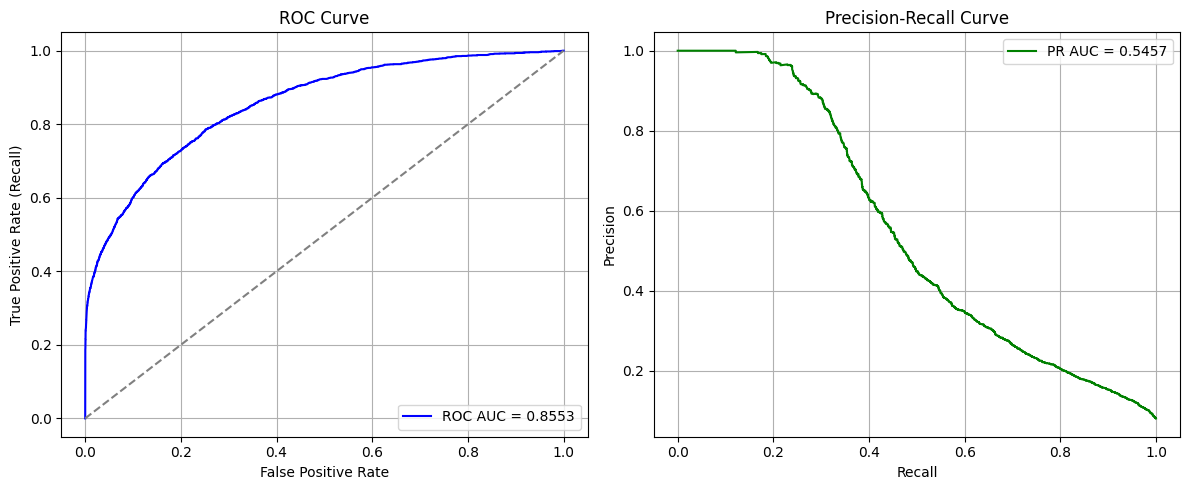

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Calculate ROC values
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall values
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
axes[0].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}', color='blue')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_title('ROC Curve')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate (Recall)')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# PR Curve
axes[1].plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}', color='green')
axes[1].set_title('Precision-Recall Curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout()
plt.show()


## 📝 Final Model Evaluation Summary

We selected a **Balanced Random Forest Classifier** as the final model for our **loan default prediction** use case, prioritizing **high recall** to minimize missed defaulters (false negatives). The composite metric used for hyper-parameter tuning was:






composite_score = 0.6 × Recall + 0.3 × F1 Score + 0.1 × PR AUC



This custom score prioritizes recall, which is essential in high-risk domains like lending — where **missing defaulters is costlier** than incorrectly flagging a few good borrowers.

---

### 📊 Model Performance Metrics (on Test Set)

| Metric       | Class 0 (Non-Default) | Class 1 (Default) |
|--------------|------------------------|--------------------|
| Precision    | 0.98                   | 0.20               |
| Recall       | 0.72                   | 0.81               |
| F1 Score     | 0.83                   | 0.33               |
| Support      | 22,403                 | 1,969              |

- **Overall Accuracy**: 73%  
- **Macro F1 Score**: 58%  
- **ROC AUC**: 0.86  
- **PR AUC**: 0.56

---

###  Key Insights

-  **High Recall for Defaulters (0.81)**  
  The model successfully identifies **81% of all actual defaulters**, which is crucial for minimizing loan risk.

-  **Low Precision for Defaulters (0.20)**  
  While false positives are high, this is acceptable in the lending context where the goal is to **avoid missed defaults**, even if it means reviewing more flagged cases.

-  **ROC AUC (0.86)** indicates strong discriminative power.  
  **PR AUC (0.56)** reflects good performance considering the **class imbalance**.

-  The **confusion matrix** shows 1,589 true positives and only 380 false negatives — a strong result for default detection.

---
###  Conclusion

The final model delivers a high recall of 81%, effectively identifying most loan defaulters — which is critical for reducing credit risk. While precision is low (20%), this is an acceptable trade-off in lending, where missing a defaulter is more costly than a false alarm.

Strong metrics like ROC AUC (0.86) and PR AUC (0.56) confirm the model's ability to handle class imbalance and separate risky applicants.

**The model is suitable for deployment in risk-sensitive environments, especially when combined with manual review or post-processing rules.**

In [31]:

# Get feature importances
importances = model.feature_importances_
features = X_train.columns  # Make sure this matches the input used to train

# Create a DataFrame for sorting and plotting
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [32]:
feat_imp_df

,Feature,Importance
38,Score_Source_3,0.25
37,Score_Source_2,0.08
42,Installment_Rate,0.04
28,Age_Days,0.04
46,Employment_Percent_Life,0.04
31,ID_Days,0.04
41,Income_to_Loan_Ratio,0.04
40,Credit_Bureau,0.04
30,Registration_Days,0.04
29,Employed_Days,0.04


C:\Users\Pankaj\AppData\Local\Temp\ipykernel_4360\800161287.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(top_n), x='Importance', y='Feature', palette='viridis')


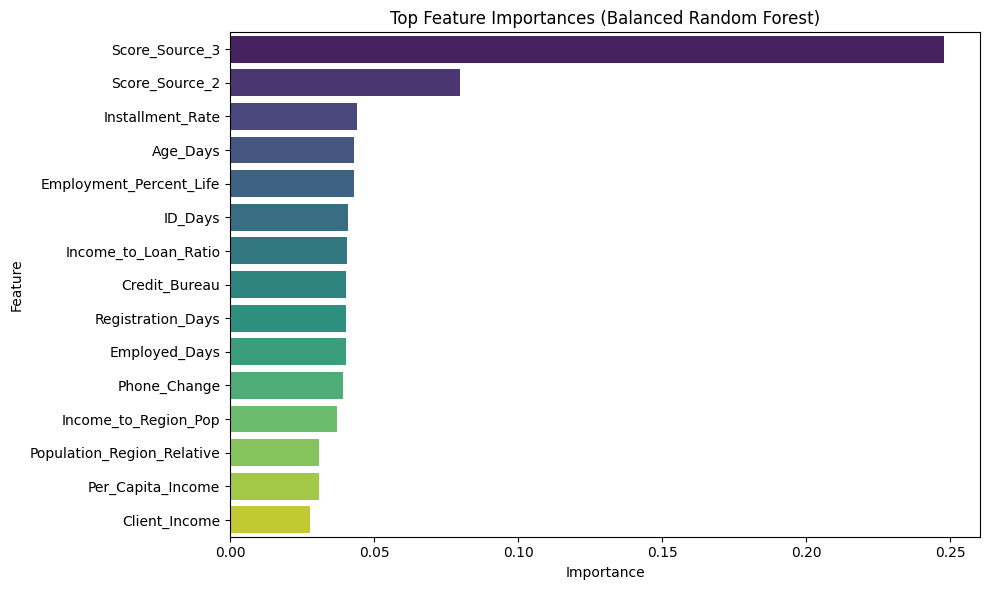

In [33]:
plt.figure(figsize=(10, 6))
top_n = 15  # Change to see more/less
sns.barplot(data=feat_imp_df.head(top_n), x='Importance', y='Feature', palette='viridis')
plt.title('Top Feature Importances (Balanced Random Forest)')
plt.tight_layout()
plt.show()


In [34]:
# In next iteration, we can even drop features with 0 feature importance

In [36]:
filepath = r"flask-deployment\models\best_model.pkl"
joblib.dump(model, filepath)

['flask-deployment\\models\\best_model.pkl']